In [ ]:
import numpy as np
import pandas as pd


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback ##학습을 시키기 위한 라이브러리를 받아옴

import time  

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])


In [ ]:
train=pd.read_csv('/content/sample_data/train.csv')
test=pd.read_csv('/content/sample_data/test.csv')
submission=pd.read_csv('/content/sample_data/sample_submission.csv')

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,5492,5,7.7,0.150,0.29,1.3,0.029,10.0,64.0,0.99320,3.35,0.39,10.1,white
5493,5493,6,6.3,0.180,0.36,1.2,0.034,26.0,111.0,0.99074,3.16,0.51,11.0,white
5494,5494,7,7.8,0.150,0.34,1.1,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,white
5495,5495,5,6.6,0.410,0.31,1.6,0.042,18.0,101.0,0.99195,3.13,0.41,10.5,white


In [ ]:
train1=pd.get_dummies(data=train,columns=['type']) #문자열 one hot encoding 으로 red white를 숫자로 처리하기 위한 코드
train1
test=pd.get_dummies(data=test,columns=['type'])
train1

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0,1
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1,0
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0,1
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0,1
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,5492,5,7.7,0.150,0.29,1.3,0.029,10.0,64.0,0.99320,3.35,0.39,10.1,0,1
5493,5493,6,6.3,0.180,0.36,1.2,0.034,26.0,111.0,0.99074,3.16,0.51,11.0,0,1
5494,5494,7,7.8,0.150,0.34,1.1,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,0,1
5495,5495,5,6.6,0.410,0.31,1.6,0.042,18.0,101.0,0.99195,3.13,0.41,10.5,0,1


In [ ]:
from tensorflow.keras.utils import to_categorical #1~9등급의 와인 품질을 아래와 같이 받아줌

y_train=to_categorical(train1.loc[:,'quality'])

y_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train=train1.loc[:,'fixed acidity':] # index는 데이터 값에 영향을 끼치는 요소로 생각하지 않아 인덱스를 제외하여 데이터를 추출하였음.
x_test=test.loc[:,'fixed acidity':]




In [ ]:
from sklearn.preprocessing import MinMaxScaler #학습을 용이하게 하기 위해서 sklearn에서 minmaxScaler를 받아옴.0~1사이의 숫자
scaler=MinMaxScaler()
scaler.fit(x_train)
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)
x_train_scaled
pd.DataFrame(x_train_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.148760,0.410000,0.036145,0.095092,0.054908,0.027778,0.179724,0.139001,0.551181,0.123596,0.318841,0.0,1.0
1,0.413223,0.353333,0.084337,0.027607,0.096506,0.031250,0.082949,0.188741,0.354331,0.207865,0.217391,1.0,0.0
2,0.338843,0.086667,0.234940,0.021472,0.079867,0.069444,0.304147,0.089647,0.244094,0.168539,0.420290,0.0,1.0
3,0.264463,0.086667,0.186747,0.082822,0.061564,0.097222,0.235023,0.130904,0.409449,0.157303,0.405797,0.0,1.0
4,0.330579,0.213333,0.156627,0.136503,0.083195,0.107639,0.396313,0.161751,0.236220,0.117978,0.420290,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,0.322314,0.046667,0.174699,0.010736,0.033278,0.031250,0.133641,0.117409,0.480315,0.095506,0.304348,0.0,1.0
5493,0.206612,0.066667,0.216867,0.009202,0.041597,0.086806,0.241935,0.069983,0.330709,0.162921,0.434783,0.0,1.0
5494,0.330579,0.046667,0.204819,0.007669,0.043261,0.104167,0.200461,0.074224,0.259843,0.280899,0.478261,0.0,1.0
5495,0.231405,0.220000,0.186747,0.015337,0.054908,0.059028,0.218894,0.093310,0.307087,0.106742,0.362319,0.0,1.0


In [ ]:
x_train_scaled.shape[1]
y_train.shape[1]
print(x_train_scaled.shape[1]) ## x_train 차원과 y_train 차원을 추출함
print(y_train.shape[1])

13
10


In [ ]:

from tensorflow.keras.regularizers import l1, l2, L1L2
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_dim=x_train_scaled.shape[1],kernel_regularizer=l2()), #정규화 추가
    keras.layers.BatchNormalization(), #BatchNormalization 추가
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

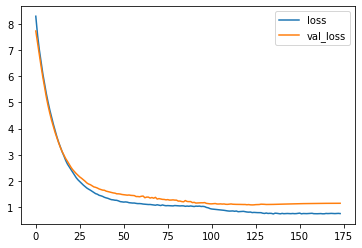

loss =  0.7624703049659729 , val_loss =  1.1542575359344482
Epoch 00174: early stopping


In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_learning_rate=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]


history=model.fit(x_train_scaled, y_train, batch_size=512 , validation_split=0.2,epochs=200, verbose=1, callbacks=callbacks)




Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f76eac8a830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


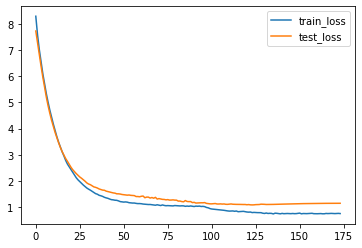

In [ ]:

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(x_train_scaled, y_train)

print("loss :", loss)
print("acc :", acc)

172/172 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.8166
loss : 0.6882181167602539
acc : 0.8166272640228271


In [ ]:
from tensorflow.python.keras.models import load_model
model.save('wine_model.h5')

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import load_model
scaler=MinMaxScaler()
x_test = test.loc[:,'fixed acidity':]
x_test_scaled=scaler.fit_transform(x_test)
x_test_scaled=pd.DataFrame(x_test_scaled)
xhat=x_test_scaled.loc[:,:]
xhat

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.421053,0.198276,0.592593,0.269406,0.048576,0.082305,0.234043,0.376667,0.169811,0.138889,0.571429,0.0,1.0
1,0.798246,0.301724,0.716049,0.054795,0.093802,0.115226,0.117021,0.816667,0.320755,0.240741,0.107143,1.0,0.0
2,0.201754,0.172414,0.333333,0.205479,0.043551,0.353909,0.609929,0.443333,0.443396,0.425926,0.178571,0.0,1.0
3,0.263158,0.060345,0.481481,0.050228,0.048576,0.164609,0.539007,0.443333,0.754717,0.222222,0.285714,0.0,1.0
4,0.228070,0.155172,0.320988,0.059361,0.008375,0.185185,0.230496,0.150667,0.415094,0.222222,0.607143,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.254386,0.439655,0.024691,0.073059,0.113903,0.189300,0.308511,0.619333,0.783019,0.277778,0.232143,1.0,0.0
996,0.394737,0.060345,0.370370,0.041096,0.053601,0.230453,0.436170,0.403333,0.471698,0.138889,0.250000,0.0,1.0
997,0.403509,0.500000,0.320988,0.045662,0.100503,0.024691,0.056738,0.596667,0.405660,0.472222,0.142857,1.0,0.0
998,0.245614,0.293103,0.234568,0.073059,0.095477,0.139918,0.102837,0.440667,0.632075,0.305556,0.446429,1.0,0.0


In [ ]:
from numpy import argmax
model = load_model('wine_model.h5')
yhat = model.predict(xhat)
result=[]
for i in range(1000):
  result.append(argmax(yhat[i]))
results=pd.DataFrame()
results['quality']=result
index=[]
for j in range(1000):
  index.append(j)
results['index']=index
results.set_index('index')

,quality
index,
0,6
1,3
2,5
3,5
4,7
...,...
995,5
996,6
997,5
